In [1]:

from scipy.stats import kstest,ttest_ind
import pandas as pd
import numpy as np

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_file = "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british/train_cohort.csv"

In [4]:
genotype_df = pd.read_csv(genotype_file)
combo_info_df = pd.read_csv(combo_file)
phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi"], dtype={"sample_names": str, "bmi": float})

In [5]:
combo_samples = set("|".join(combo_info_df.combo_samples).split("|"))

In [6]:
combo_genes = set("|".join(combo_info_df.uniq_items.str.replace("Input_", "")).split("|"))

In [7]:
# only keep the combo genes
combo_gene_df = genotype_df.loc[genotype_df.gene.isin(combo_genes)]
# set samples as str type
combo_gene_df.loc[:, "samples"] = combo_gene_df.samples.str.split(",")
# explode by samples
combo_gene_df = combo_gene_df.explode("samples")
# create one hot encoded data
combo_gene_df = pd.crosstab(combo_gene_df.samples, combo_gene_df.gene)


In [8]:
single_hit_samples = set(combo_gene_df.loc[combo_gene_df.sum(axis=1)<2].index)

In [9]:
single_hit_pheno = phenotype_df.loc[phenotype_df.sample_names.isin(single_hit_samples)]

In [10]:
combo_pheno = phenotype_df.loc[phenotype_df.sample_names.isin(combo_samples)]

In [11]:
single_hit_pheno["mutation"] = "single hit"
combo_pheno["mutation"] = "combo"

/tmp/ipykernel_10649/3140809516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hit_pheno["mutation"] = "single hit"
/tmp/ipykernel_10649/3140809516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_pheno["mutation"] = "combo"


In [12]:
oligo_table = pd.concat((single_hit_pheno, combo_pheno))

# Cumulative histplot

In [13]:
sns.color_palette("Reds", 15).as_hex()

['#feeae1',
 '#fee0d2',
 '#fdcdb9',
 '#fcbba1',
 '#fca689',
 '#fc9272',
 '#fb7d5d',
 '#fb694a',
 '#f5523a',
 '#ee3a2c',
 '#dc2924',
 '#ca181d',
 '#b71319',
 '#a30f15',
 '#840711']

In [14]:
list(sns.color_palette("Reds", 15).as_hex())[13]

'#a30f15'

In [15]:
sns.color_palette("Blues", 15).as_hex()

['#eaf3fb',
 '#deebf7',
 '#d2e3f3',
 '#c6dbef',
 '#b2d2e8',
 '#9dcae1',
 '#84bcdb',
 '#6aaed6',
 '#56a0ce',
 '#4191c6',
 '#3181bd',
 '#2070b4',
 '#1460a8',
 '#08509b',
 '#084082']

In [16]:
list(sns.color_palette("Blues", 15).as_hex())[13]

'#08509b'

In [17]:
oligo_df = oligo_table

In [18]:
single_hit_pheno.bmi.mean(), combo_pheno.bmi.mean()

(27.38663947409488, 31.389483228686352)

(-0.05, 1.0)

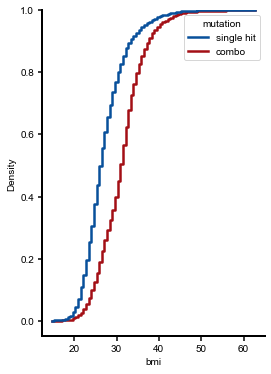

In [19]:


# Define Canvas
fig,ax = plt.subplots(1, 1, figsize=(4, 6))

sns.histplot(
    data=oligo_df,
    x="bmi", hue="mutation",
    hue_order=["single hit", "combo"],
    palette=["#08509b", "#a30f15", ],
    log_scale=False, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
    linewidth=2.5,ax=ax
)

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.05, 1.0)

In [20]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/white_british/data/oligogenic/single_combo_compare.pdf"
save_pdf(save_file, fig)

In [21]:
ttest_ind(single_hit_pheno.bmi, combo_pheno.bmi, alternative="less")

TtestResult(statistic=-31.94884541662241, pvalue=1.4605695305614366e-215, df=12327.0)

In [22]:
kstest(single_hit_pheno.bmi, combo_pheno.bmi, alternative="greater")

KstestResult(statistic=0.38061825310826886, pvalue=4.5495627403877655e-223, statistic_location=29.537, statistic_sign=1)

# Other attempts

/tmp/ipykernel_10649/2987522493.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Single Hit", "Combo carriers"], rotation=45, fontsize=18)
/tmp/ipykernel_10649/2987522493.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


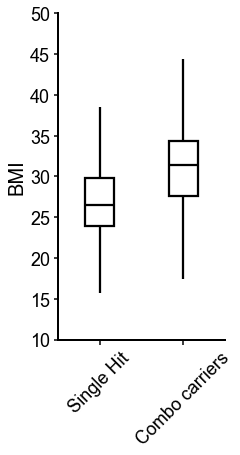

In [23]:
boxdf = oligo_df

fig,ax = plt.subplots(figsize=(3, 6))

# Box Plot
sns_ax = sns.boxplot(
    data=boxdf,
    # palette=["#c1272d", "#00ADEE"],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="mutation",
    y="bmi",
    color="k",
    orient="v",
    legend=False,
    width=0.35, linewidth=2.25, fliersize=0, capprops={'color':'none'}, boxprops={'facecolor':'none', 'edgecolor':'k'}
    )

# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
ax.set_ylim((10, 50))
# ax.set_ylabel('Percentage')
ax.set_xticklabels(["Single Hit", "Combo carriers"], rotation=45, fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("BMI", fontsize=20)

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);


In [24]:
ttest_ind(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi, alternative="less"), kstest(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi)

NameError: name 'single_hit_pheno_c2' is not defined

In [ ]:
ttest_ind(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi, alternative="less"), kstest(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi)

(Ttest_indResult(statistic=-26.510898062286397, pvalue=8.810889200687164e-155),
 KstestResult(statistic=0.4330296110581548, pvalue=2.5767301611682205e-149))